<a href="https://colab.research.google.com/github/Thabang019/compass/blob/main/BiasTectector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias Audit Report
**Course:** AI & Ethics  
**Author:** Polite Dlamini

## Project Description  
This notebook performs a **bias audit** on:  
- Text inputs  
- Images  
- Documents (PDF/DOCX extracted text)  

It uses:  
- HuggingFace Transformers  
- CLIP for image content analysis  
- Zero-shot classification for text bias  
- Matplotlib for visualizations  

## Deliverables  
Bias detection functions  
Visualizations  
Summary analysis  
5-minute presentation  


In [1]:
!pip install transformers sentencepiece accelerate --quiet
!pip install pillow pdfplumber python-docx --quiet

from transformers import pipeline, CLIPProcessor, CLIPModel
from PIL import Image
import pdfplumber
import docx
import matplotlib.pyplot as plt
import torch
import numpy as np
print("Environment ready — all libraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.3 MB/s eta 0:00:00
Environment ready — all libraries installed successfully!


In [2]:
# TEXT BIAS MODEL
text_bias_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

bias_labels = ["biased", "not biased", "hate speech", "stereotype", "toxic"]

# IMAGE BIAS MODEL (CLIP)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
def detect_text_bias(text):
    result = text_bias_classifier(text, candidate_labels=bias_labels)
    return result


In [4]:
def detect_image_bias(image_path):
    image = Image.open(image_path)

    descriptions = [
        "This image contains biased or stereotypical content",
        "This image is neutral and not biased"
    ]

    inputs = clip_processor(
        text=descriptions,
        images=image,
        return_tensors="pt",
        padding=True
    )

    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    return {
        "biased_score": float(probs[0][0]),
        "not_biased_score": float(probs[0][1])
    }


In [6]:
def extract_text_from_pdf(path):
    text = ""
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""
    return text

def extract_text_from_docx(path):
    doc = docx.Document(path)
    return "\n".join([p.text for p in doc.paragraphs])

def analyze_document(path):
    if path.endswith(".pdf"):
        text = extract_text_from_pdf(path)
    elif path.endswith(".docx"):
        text = extract_text_from_docx(path)
    else:
        raise ValueError("Unsupported file format")

    return detect_text_bias(text)


In [7]:
def plot_bias_scores(result):
    labels = result["labels"]
    scores = result["scores"]

    plt.figure(figsize=(7,5))
    plt.bar(labels, scores)
    plt.title("Bias Probability Scores")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.show()


Check if text is biase

In [9]:
sample_text = "Women are naturally better at nurturing roles like teaching and nursing than men are."
result = detect_text_bias(sample_text)
result


{'sequence': 'Women are naturally better at nurturing roles like teaching and nursing than men are.',
 'labels': ['biased', 'not biased', 'stereotype', 'hate speech', 'toxic'],
 'scores': [0.3823131024837494,
  0.348223477602005,
  0.23977433145046234,
  0.017116175964474678,
  0.012572984211146832]}

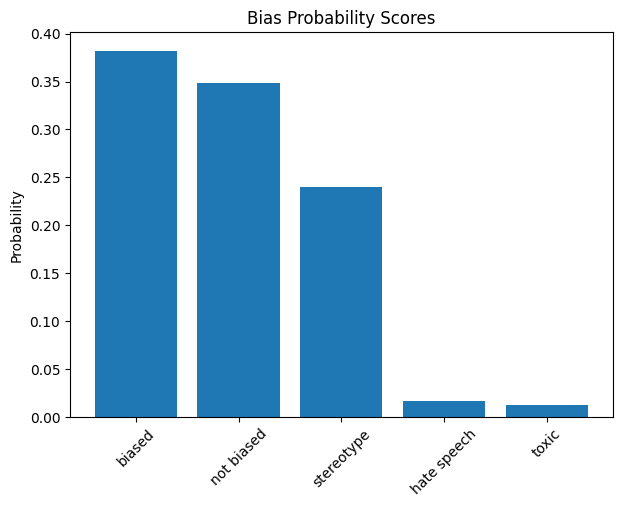

In [10]:
plot_bias_scores(result)


Check Bias in an Image

In [15]:
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image_bias = detect_image_bias(image_path)
image_bias


Saving bias-detection-sampling-bias.webp to bias-detection-sampling-bias.webp


/tmp/ipython-input-2364435671.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  "biased_score": float(probs[0][0]),


{'biased_score': 0.6358837485313416, 'not_biased_score': 0.3641161620616913}

Check Bias in a PDF/DOCX

In [14]:
from google.colab import files
uploaded = files.upload()

file_path = list(uploaded.keys())[0]
document_bias = analyze_document(file_path)
document_bias


Saving Cover Letter.pdf to Cover Letter.pdf


{'sequence': 'Polite Dlamini\npolitedlamini305@gmail.com | +27 791 359 314\nwww.linkedin.com/in/polite-dlamini-752203214\ngithub.com/PoliteDredd\n09/07/2025\nHiring Manager\nSanlam Group Technology\nCape Town, South Africa\nRE: Application for Intern: Data Governance Full-Stack Developer Position\nDear Hiring Manager,\nI am writing to express my keen interest in the Intern: Data Governance Full-Stack\nDeveloper role at Sanlam, as advertised. With a Diploma in ICT: Application Development\nand a strong foundation in data systems, I am eager to contribute to Sanlam’s vision of using\ntechnology to drive digital and data transformation.\nDuring my studies, I was involved in various academic projects that focused on data-driven\napplications, database design, and back-end development, which sparked my interest in\ndata governance and analytics. I also gained hands-on experience working with SQL and\nmanaging system integrations. My time maintaining and updating websites for VSOFT\nSystems 

Overall summary

In [16]:
def generate_summary(text_result=None, image_result=None, doc_result=None):
    print("=== BIAS AUDIT SUMMARY ===\n")

    if text_result:
        print("TEXT BIAS RESULT:")
        print(text_result, "\n")

    if image_result:
        print("IMAGE BIAS RESULT:")
        print(image_result, "\n")

    if doc_result:
        print("DOCUMENT BIAS RESULT:")
        print(doc_result, "\n")

    print("General Note:")
    print("Higher scores in 'biased' or 'stereotype' suggest harmful bias.")
